In [1]:
import dask.dataframe as dd 
import numpy as np
from sklearn.preprocessing import LabelEncoder,RobustScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import seaborn as sns
from collections import Counter
from ctgan import CTGANSynthesizer
from ctgan import load_demo
import warnings
from utils import *
warnings.filterwarnings('ignore')

In [2]:
data=dd.read_csv("../data/application_train.csv").compute()
print(data.shape)

(307511, 122)


In [3]:
data=cleaning(data)

Mem. usage decreased to 94.72 Mb (67.2% reduction)


In [5]:
categorical=data.select_dtypes('object').columns 

In [6]:
# model = CTGANSynthesizer()
# model.fit(data)

In [7]:
# samples = model.sample(1000)

In [8]:
for i in categorical:
    lc=LabelEncoder()
    data[i]=lc.fit_transform(data[i])

In [9]:
# data=dd.get_dummies(data,drop_first=True)

In [10]:
cor_matrix = data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data.drop(to_drop,axis=1,inplace=True)

In [11]:
numeric=list(data.select_dtypes('float64').columns.values) +list(data.select_dtypes('float16').columns.values) + list(data.select_dtypes('int32').columns.values)+ list(data.select_dtypes('int16').columns.values)+ list(data.select_dtypes('int8').columns.values)+list(data.select_dtypes('float32').columns.values)

In [12]:
data.shape

(307511, 86)

In [13]:
for i in numeric :
    if i not in categorical:
        rs=RobustScaler()
        data[i]=rs.fit_transform(data[[i]])

In [14]:
def preprocessing(df):
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']

    return X, y

In [15]:
def evaluationClassification(model):
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("accuracy",accuracy_score(y_test, y_pred))
    a,b,threshold=roc_curve(y_test,y_pred)
    auc_pred=auc(a,b)
    print("auc ",auc_pred)
    print("roc_auc_score ",roc_auc_score(y_test, y_pred))
    print("f1 score : " ,f1_score(y_test, y_pred))
    plt.plot(a,b)
    plt.show()


In [16]:
def evaluationClassificationThreshold(model,threshold):
    model.fit(X_train, y_train)
    y_pred=model.predict_proba(X_test)

    y_pred= (y_pred [:,1]>= 0.2).astype('int') 


    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("accuracy",accuracy_score(y_test, y_pred))
    a,b,threshold=roc_curve(y_test,y_pred)
    auc_pred=auc(a,b)
    print("auc ",auc_pred)
    print("roc_auc_score ",roc_auc_score(y_test, y_pred))
    print("f1 score : " ,f1_score(y_test, y_pred))
    plt.plot(a,b)
    plt.show()


In [17]:
def BestThreshold(rf_model):
    step_factor = 0.05 
    threshold_value = 0.2 
    roc_score=0
    predicted_proba = rf_model.predict_proba(X_test)
    while threshold_value <=0.8: 
        temp_thresh = threshold_value
        predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') 
        print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
        if roc_score<roc_auc_score(y_test, predicted): 
            roc_score = roc_auc_score(y_test, predicted)
            thrsh_score = threshold_value
        threshold_value = threshold_value + step_factor
    print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

<h1>Regression logistique</h1>

In [47]:
data_lr=data.copy()

In [48]:
from sklearn.linear_model import LogisticRegression


In [49]:
model=LogisticRegression()

In [50]:
X,y=preprocessing(data_lr)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56550
         1.0       0.35      0.00      0.01      4953

    accuracy                           0.92     61503
   macro avg       0.63      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503

[[56505    45]
 [ 4929    24]]
accuracy 0.9191258962977416
auc  0.5020248960922326
roc_auc_score  0.5020248960922326
f1 score :  0.009557945041816009


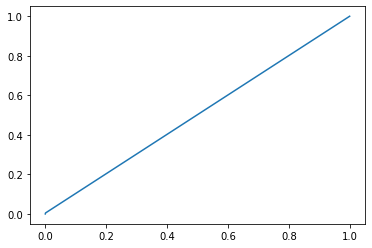

In [51]:
evaluationClassification(model)

In [52]:
import statsmodels.api as sm

In [53]:
log_reg = sm.Logit(y_train, X_train).fit()

         Current function value: 0.256474
         Iterations: 35


c:\Users\Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
l=[]
b=[]
j=0
for i in log_reg.conf_int().index:
    if(log_reg.pvalues[i]>0.05):
        j+=1
        l.append(i)
        b.append(i)

In [ ]:
log_reg.summary()

* On Supprime les colonnes dont P>|z|	 > 0.05

In [55]:
X.drop(l,inplace=True,axis=1)

In [56]:
X.shape

(307511, 51)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56550
         1.0       0.34      0.01      0.02      4953

    accuracy                           0.92     61503
   macro avg       0.63      0.50      0.49     61503
weighted avg       0.87      0.92      0.88     61503

[[56467    83]
 [ 4911    42]]
accuracy 0.9188007089085085
auc  0.5035059907962434
roc_auc_score  0.5035059907962434
f1 score :  0.016541945647892874


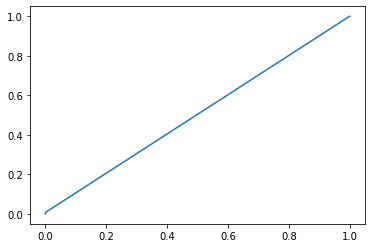

In [57]:
model=LogisticRegression()
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
evaluationClassification(model)

In [58]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.256567
         Iterations 8


In [59]:
l=[]
j=0
for i in log_reg.conf_int().index:
    if(log_reg.pvalues[i]>0.05):
        j+=1
        l.append(i)
        b.append(i)

In [60]:
X.drop(l,inplace=True,axis=1)
X.shape

(307511, 50)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56550
         1.0       0.36      0.01      0.01      4953

    accuracy                           0.92     61503
   macro avg       0.64      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503

[[56496    54]
 [ 4923    30]]
accuracy 0.9190771181893567
auc  0.502551014014495
roc_auc_score  0.502551014014495
f1 score :  0.011911852293031567


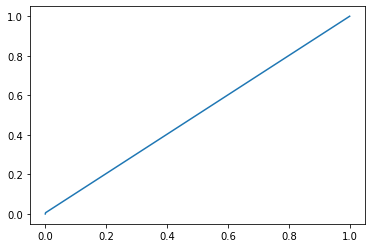

In [61]:
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
evaluationClassification(model)

In [62]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.256576
         Iterations 8


In [63]:
l=[]
j=0
for i in log_reg.conf_int().index:
    if(log_reg.pvalues[i]>0.05):
        j+=1
        l.append(i)
        b.append(i)

In [66]:
l

['NAME_INCOME_TYPE']

In [65]:
X.drop(l,inplace=True,axis=1)
X.shape

(307511, 49)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56550
         1.0       0.37      0.00      0.01      4953

    accuracy                           0.92     61503
   macro avg       0.65      0.50      0.48     61503
weighted avg       0.88      0.92      0.88     61503

[[56518    32]
 [ 4934    19]]
accuracy 0.9192559712534348
auc  0.5016350940217355
roc_auc_score  0.5016350940217355
f1 score :  0.0075939248601119115


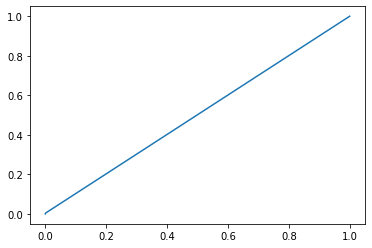

In [67]:
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
evaluationClassification(model)

In [68]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.256584
         Iterations 8


In [69]:
l=[]
j=0
for i in log_reg.conf_int().index:
    if(log_reg.pvalues[i]>0.05):
        j+=1
        l.append(i)
        b.append(i)

In [70]:
l

[]

In [31]:
# X,y=preprocessing(data)
# X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

In [32]:
counter = Counter(y_train)
counter

Counter({0: 226136, 1: 19872})

In [71]:
risque=data[data_lr["TARGET"]==1]
non_risque=data[data_lr["TARGET"]==0].sample(n=24825)

In [72]:
new=dd.concat([risque,non_risque]).compute()
new.shape

(49650, 86)

In [73]:
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      5008
         1.0       0.67      0.67      0.67      4922

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930

[[3362 1646]
 [1630 3292]]
accuracy 0.6700906344410876
auc  0.6700798429948085
roc_auc_score  0.6700798429948085
f1 score :  0.6677484787018255


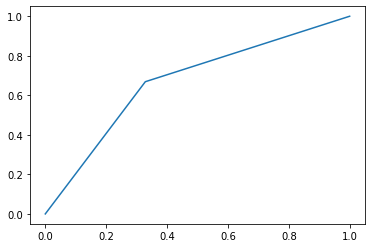

In [74]:
model=LogisticRegression()
evaluationClassification(model)

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      5008
         1.0       0.67      0.67      0.67      4922

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930

[[3380 1628]
 [1648 3274]]
accuracy 0.6700906344410876
auc  0.6700484426056059
roc_auc_score  0.6700484426056059
f1 score :  0.6665309446254072


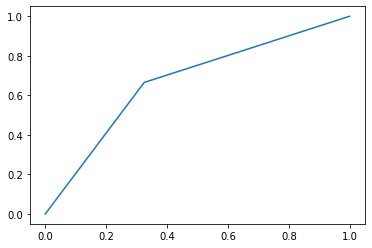

In [75]:
X.drop(b,inplace=True,axis=1)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
model=LogisticRegression()
evaluationClassification(model)

In [76]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     56533
         1.0       0.15      0.57      0.24      4970

    accuracy                           0.71     61503
   macro avg       0.55      0.64      0.53     61503
weighted avg       0.89      0.71      0.77     61503

[[40921 15612]
 [ 2161  2809]]
accuracy 0.711022226558054
auc  0.6445169291090145
roc_auc_score  0.6445169291090145
f1 score :  0.24017784618015475


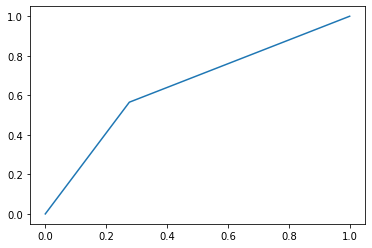

In [77]:
evaluationClassification(LogisticRegression())

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56550
         1.0       0.37      0.00      0.01      4953

    accuracy                           0.92     61503
   macro avg       0.65      0.50      0.48     61503
weighted avg       0.88      0.92      0.88     61503

[[56518    32]
 [ 4934    19]]
accuracy 0.9192559712534348
auc  0.5016350940217355
roc_auc_score  0.5016350940217355
f1 score :  0.0075939248601119115


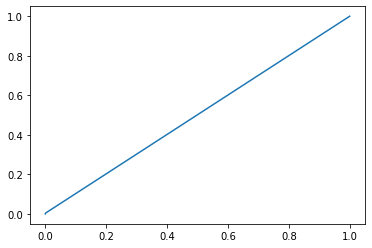

In [78]:
X.drop(b,inplace=True,axis=1)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
model=LogisticRegression()
evaluationClassification(model)

In [97]:
X,y=preprocessing(data_lr)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
model=LogisticRegression()
model.fit(X_train,y_train)   
model.predict_proba(X_test)
BestThreshold(model)

Threshold 0.2 -- 0.580059316192903
Threshold 0.25 -- 0.5513617661187578
Threshold 0.3 -- 0.5324573751888442
Threshold 0.35 -- 0.5183486149111998
Threshold 0.39999999999999997 -- 0.5091488961757764
Threshold 0.44999999999999996 -- 0.5042679114712784
Threshold 0.49999999999999994 -- 0.5020248960922326
Threshold 0.5499999999999999 -- 0.5005298077793326
Threshold 0.6 -- 0.5003419035485286
Threshold 0.65 -- 0.5000567402549483
Threshold 0.7000000000000001 -- 0.499973474801061
Threshold 0.7500000000000001 -- 0.49999115826702034
---Optimum Threshold --- 0.2 --ROC-- 0.580059316192903


              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     56550
         1.0       0.25      0.22      0.23      4953

    accuracy                           0.88     61503
   macro avg       0.59      0.58      0.58     61503
weighted avg       0.88      0.88      0.88     61503

[[53274  3276]
 [ 3873  1080]]
accuracy 0.8837617677186479
auc  0.580059316192903
roc_auc_score  0.580059316192903
f1 score :  0.23203351595230423


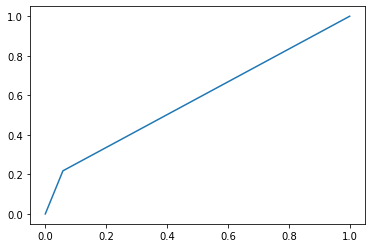

In [98]:
evaluationClassificationThreshold(LogisticRegression(),0.2)

In [99]:
X.drop(b,inplace=True,axis=1)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)
model=LogisticRegression()
model.fit(X_train,y_train)   
model.predict_proba(X_test)
BestThreshold(model)

Threshold 0.2 -- 0.5775096945773025
Threshold 0.25 -- 0.5471623606730857
Threshold 0.3 -- 0.5303410681091919
Threshold 0.35 -- 0.516922032623906
Threshold 0.39999999999999997 -- 0.5069221022438509
Threshold 0.44999999999999996 -- 0.5037292619589661
Threshold 0.49999999999999994 -- 0.5016350940217355
Threshold 0.5499999999999999 -- 0.5003809603375174
Threshold 0.6 -- 0.5001576891747949
Threshold 0.65 -- 0.4999823165340407
Threshold 0.7000000000000001 -- 0.49999115826702034
Threshold 0.7500000000000001 -- 0.5
---Optimum Threshold --- 0.2 --ROC-- 0.5775096945773025


              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     56550
         1.0       0.25      0.21      0.23      4953

    accuracy                           0.89     61503
   macro avg       0.59      0.58      0.58     61503
weighted avg       0.88      0.89      0.88     61503

[[53488  3062]
 [ 3917  1036]]
accuracy 0.8865258605271288
auc  0.5775096945773025
roc_auc_score  0.5775096945773025
f1 score :  0.22892498066511988


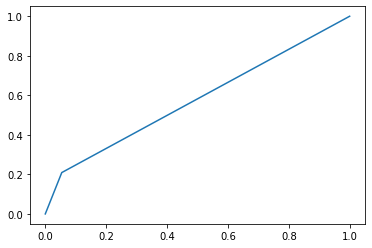

In [100]:
evaluationClassificationThreshold(LogisticRegression(),0.2)

<h1>Decision tree classifier</h1>

In [14]:
data_dtc=data.copy()

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [16]:
dtc=DecisionTreeClassifier()

In [106]:
X,y=preprocessing(data_dtc)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,stratify=y)

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     56538
         1.0       0.15      0.18      0.16      4965

    accuracy                           0.85     61503
   macro avg       0.54      0.54      0.54     61503
weighted avg       0.86      0.85      0.86     61503

[[51447  5091]
 [ 4089   876]]
accuracy 0.8507389883420321
auc  0.5431947061458224
roc_auc_score  0.5431947061458224
f1 score :  0.1602634467618002


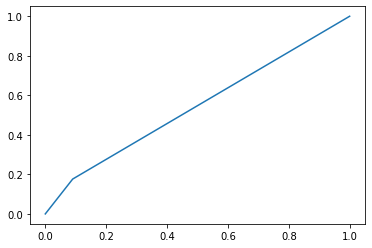

In [18]:
evaluationClassification(dtc)

[Text(459.07525492810817, 539.4818181818182, 'EXT_SOURCE <= 0.415\ngini = 0.149\nsamples = 246008\nvalue = [226102, 19906]\nclass = 0'),
 Text(142.96834550855996, 531.2454545454545, 'EXT_SOURCE <= 0.291\ngini = 0.305\nsamples = 47022\nvalue = [38195, 8827]\nclass = 0'),
 Text(36.28916393228662, 523.0090909090909, 'EXT_SOURCE <= 0.234\ngini = 0.417\nsamples = 7974\nvalue = [5613, 2361]\nclass = 0'),
 Text(15.047746979497946, 514.7727272727273, 'DAYS_BIRTH <= 33.5\ngini = 0.466\nsamples = 2635\nvalue = [1662, 973]\nclass = 0'),
 Text(4.91470905848024, 506.53636363636366, 'EXT_SOURCE <= 0.1\ngini = 0.441\nsamples = 1733\nvalue = [1165, 568]\nclass = 0'),
 Text(0.8360625239332254, 498.3, 'AMT_CREDIT <= 854325.0\ngini = 0.479\nsamples = 68\nvalue = [27, 41]\nclass = 1'),
 Text(0.7491988850830202, 490.06363636363636, 'AMT_CREDIT <= 222021.0\ngini = 0.46\nsamples = 64\nvalue = [23, 41]\nclass = 1'),
 Text(0.43431819425102625, 481.82727272727277, 'HOUR_APPR_PROCESS_START <= 14.0\ngini = 0.475\

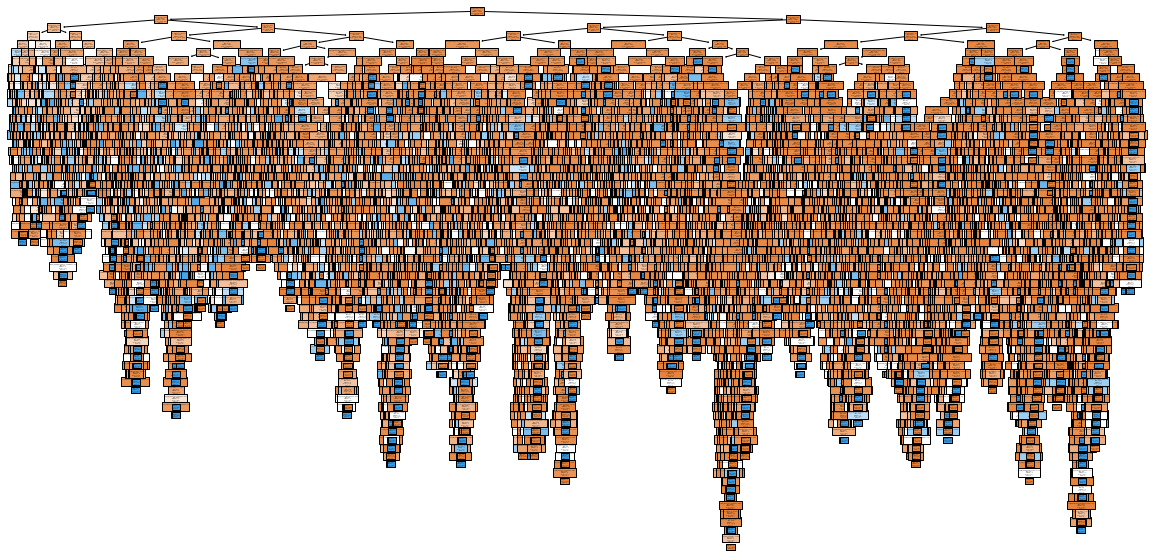

In [36]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtc,feature_names=X_train.columns,filled=True,class_names=['0','1'])

In [ ]:
print(tree.export_text(dtc,feature_names=X_train.columns,class_names=['0','1']))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56536     2]
 [ 4965     0]]
accuracy 0.9192397118839731
auc  0.4999823127807846
roc_auc_score  0.4999823127807846
f1 score :  0.0


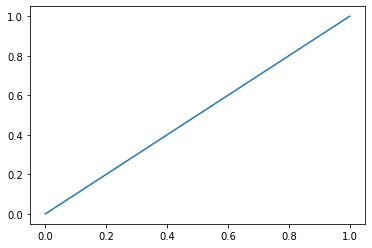

In [19]:
dtc=DecisionTreeClassifier(max_depth=5)
evaluationClassification(dtc)

[Text(558.0, 498.3, 'EXT_SOURCE <= 0.397\ngini = 0.149\nsamples = 246008\nvalue = [226132, 19876]\nclass = 0'),
 Text(279.0, 407.70000000000005, 'EXT_SOURCE <= 0.265\ngini = 0.297\nsamples = 54540\nvalue = [44657, 9883]\nclass = 0'),
 Text(139.5, 317.1, 'EXT_SOURCE <= 0.15\ngini = 0.377\nsamples = 16924\nvalue = [12656, 4268]\nclass = 0'),
 Text(69.75, 226.5, 'DAYS_BIRTH <= -18508.0\ngini = 0.433\nsamples = 4404\nvalue = [3006, 1398]\nclass = 0'),
 Text(34.875, 135.89999999999998, 'AMT_ANNUITY <= 20373.75\ngini = 0.339\nsamples = 1076\nvalue = [843, 233]\nclass = 0'),
 Text(17.4375, 45.299999999999955, 'gini = 0.274\nsamples = 543\nvalue = [454, 89]\nclass = 0'),
 Text(52.3125, 45.299999999999955, 'gini = 0.394\nsamples = 533\nvalue = [389, 144]\nclass = 0'),
 Text(104.625, 135.89999999999998, 'AMT_CREDIT <= 219456.0\ngini = 0.455\nsamples = 3328\nvalue = [2163, 1165]\nclass = 0'),
 Text(87.1875, 45.299999999999955, 'gini = 0.378\nsamples = 648\nvalue = [484, 164]\nclass = 0'),
 Text(1

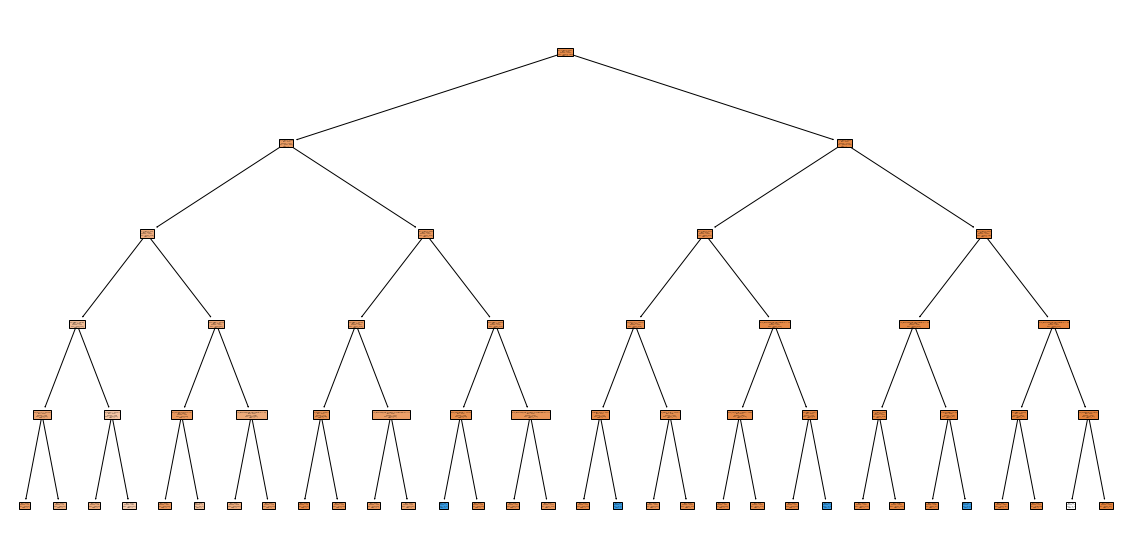

In [43]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtc,feature_names=X_train.columns,filled=True,class_names=['0','1'])

In [44]:
# save_decision_trees_as_png(dtc, 5, X_train.columns, ["0","1"])

Decision Tree 6 saved as png file


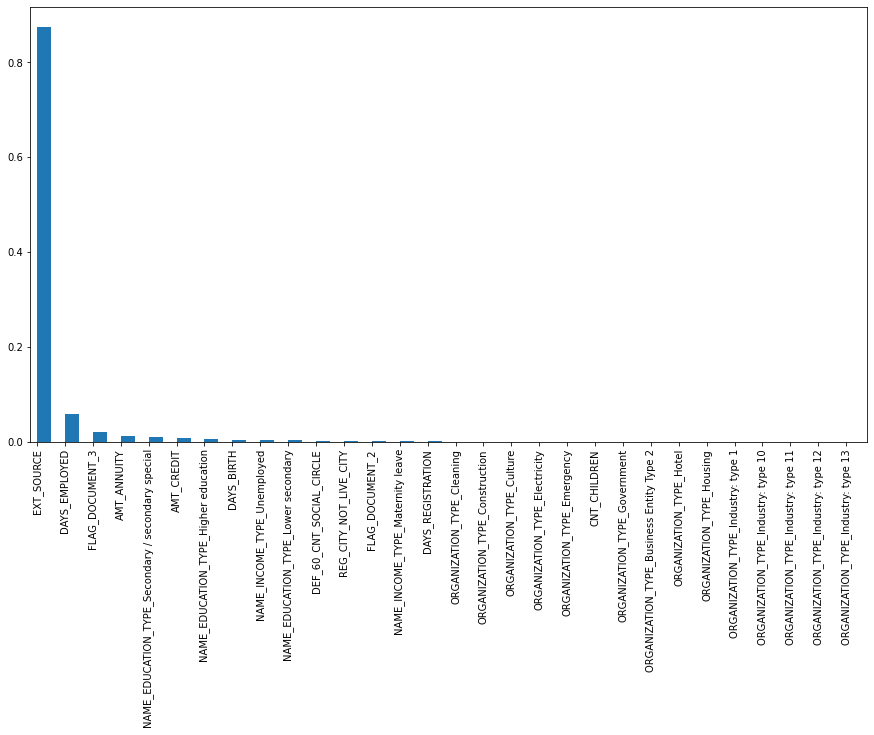

In [20]:
import pandas as pd
plt.figure(figsize=(15,8))
feature_importance= pd.Series(dtc.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.show()

In [20]:
risque=data[data_dtc["TARGET"]==1]
non_risque=data[data_dtc["TARGET"]==0].sample(n=24825)

new=dd.concat([risque,non_risque]).compute()
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

              precision    recall  f1-score   support

         0.0       0.68      0.64      0.66      4961
         1.0       0.66      0.70      0.68      4969

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930

[[3159 1802]
 [1499 3470]]
accuracy 0.6675730110775429
auc  0.6675482123412284
roc_auc_score  0.6675482123412284
f1 score :  0.6776681964651889


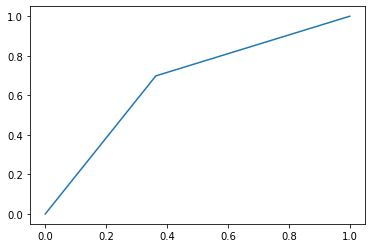

In [21]:
evaluationClassification(dtc)

* data augmentation

In [22]:
X,y=preprocessing(data_dtc)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85     56586
         1.0       0.14      0.45      0.22      4917

    accuracy                           0.74     61503
   macro avg       0.54      0.61      0.53     61503
weighted avg       0.88      0.74      0.80     61503

[[43484 13102]
 [ 2720  2197]]
accuracy 0.7427442563777377
auc  0.6076378971404586
roc_auc_score  0.6076378971404586
f1 score :  0.21735259200633164


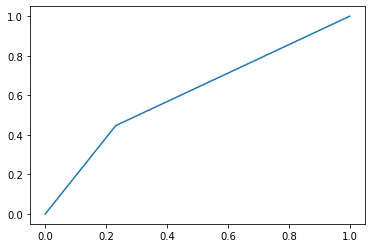

In [23]:
evaluationClassification(dtc)

* Pruning

In [104]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [299]:
dtc=DecisionTreeClassifier()
grid_params={'ccp_alpha':np.linspace(0.00001,0.0001,100)}
grid=GridSearchCV(dtc,grid_params,cv=5,n_jobs=6)
grid.fit(X_test,y_test)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=6,
             param_grid={'ccp_alpha': array([1.00000000e-05, 1.09090909e-05, 1.18181818e-05, 1.27272727e-05,
       1.36363636e-05, 1.45454545e-05, 1.54545455e-05, 1.63636364e-05,
       1.72727273e-05, 1.81818182e-05, 1.90909091e-05, 2.00000000e-05,
       2.09090909e-05, 2.18181818e-05, 2.27272727e-05, 2.36363636e-05,
       2.45454545e-05, 2....
       7.90909091e-05, 8.00000000e-05, 8.09090909e-05, 8.18181818e-05,
       8.27272727e-05, 8.36363636e-05, 8.45454545e-05, 8.54545455e-05,
       8.63636364e-05, 8.72727273e-05, 8.81818182e-05, 8.90909091e-05,
       9.00000000e-05, 9.09090909e-05, 9.18181818e-05, 9.27272727e-05,
       9.36363636e-05, 9.45454545e-05, 9.54545455e-05, 9.63636364e-05,
       9.72727273e-05, 9.81818182e-05, 9.90909091e-05, 1.00000000e-04])})

In [301]:
grid.best_params_

{'ccp_alpha': 9.636363636363637e-05}

In [283]:
grid.best_score_

0.9197274912542639

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56570
           1       0.00      0.00      0.00      4933

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56570     0]
 [ 4933     0]]
accuracy 0.9197925304456693
0.9197925304456693
auc  0.5


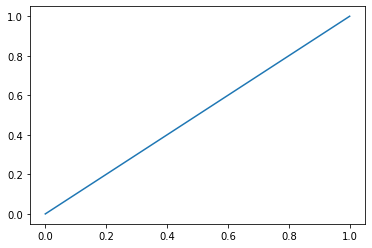

In [91]:
dtc=DecisionTreeClassifier(ccp_alpha=9.636363636363637e-05)
evaluationClassification(dtc)

In [92]:
dtc.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03458967, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0132324 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.95217792, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

[Text(643.8461538461538, 489.24, 'EXT_SOURCE <= 0.394\ngini = 0.149\nsamples = 246008\nvalue = [226116, 19892]\nclass = 0'),
 Text(429.23076923076917, 380.52000000000004, 'EXT_SOURCE <= 0.259\ngini = 0.3\nsamples = 53176\nvalue = [43420, 9756]\nclass = 0'),
 Text(257.53846153846155, 271.8, 'DAYS_EMPLOYED <= 8.5\ngini = 0.381\nsamples = 15799\nvalue = [11752, 4047]\nclass = 0'),
 Text(171.69230769230768, 163.08000000000004, 'EXT_SOURCE <= 0.178\ngini = 0.407\nsamples = 11702\nvalue = [8377, 3325]\nclass = 0'),
 Text(85.84615384615384, 54.360000000000014, 'gini = 0.441\nsamples = 4711\nvalue = [3165, 1546]\nclass = 0'),
 Text(257.53846153846155, 54.360000000000014, 'gini = 0.379\nsamples = 6991\nvalue = [5212, 1779]\nclass = 0'),
 Text(343.38461538461536, 163.08000000000004, 'gini = 0.29\nsamples = 4097\nvalue = [3375, 722]\nclass = 0'),
 Text(600.9230769230769, 271.8, 'EXT_SOURCE <= 0.332\ngini = 0.259\nsamples = 37377\nvalue = [31668, 5709]\nclass = 0'),
 Text(515.0769230769231, 163.08

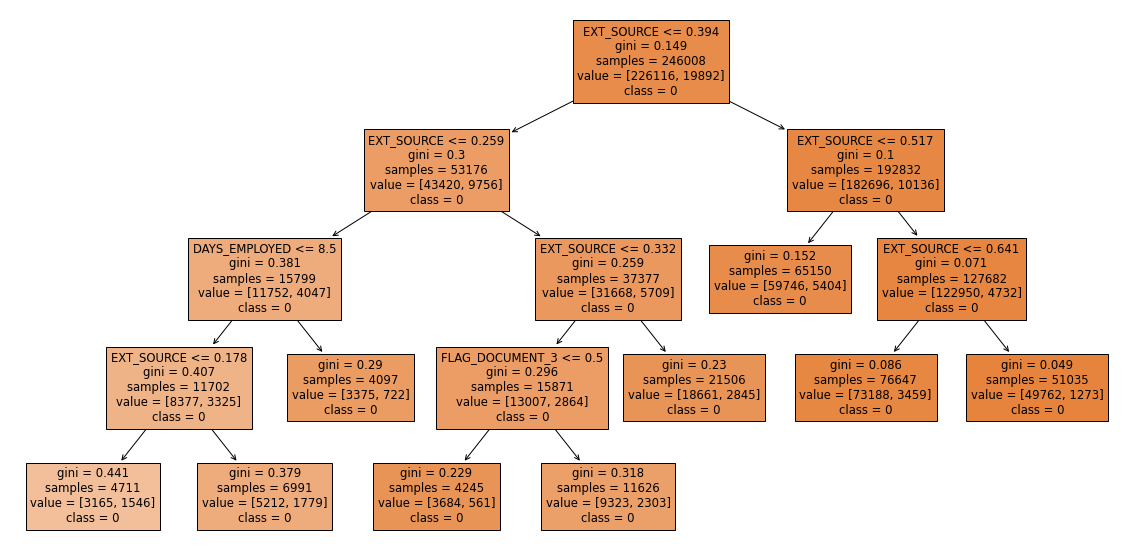

In [93]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtc,feature_names=X_train.columns,filled=True,class_names=['0','1'])

* On peut rien conclure abscence de la classe 1 dans l'arbre ==> decisions commerciales impossible

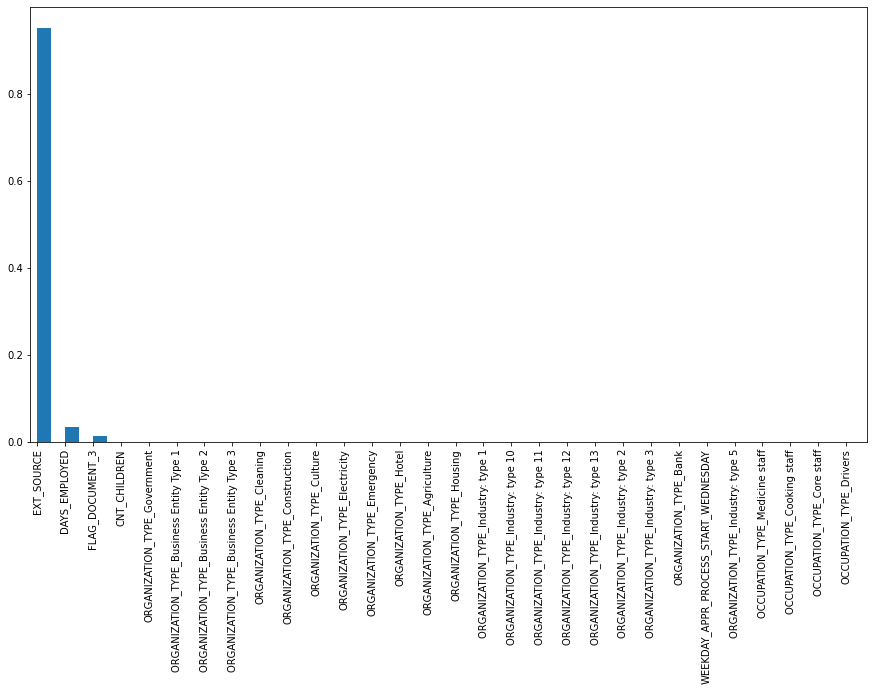

In [94]:
import pandas as pd
plt.figure(figsize=(15,8))
feature_importance= pd.Series(dtc.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.show()

<h1>Random Forest Classifier </h1>

In [107]:
data_rfc=data.copy()

In [108]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56586
         1.0       0.31      0.01      0.01      4917

    accuracy                           0.92     61503
   macro avg       0.62      0.50      0.49     61503
weighted avg       0.87      0.92      0.88     61503

[[56508    78]
 [ 4882    35]]
accuracy 0.9193535274702047
auc  0.5028698643263348
roc_auc_score  0.5028698643263348
f1 score :  0.013916500994035784


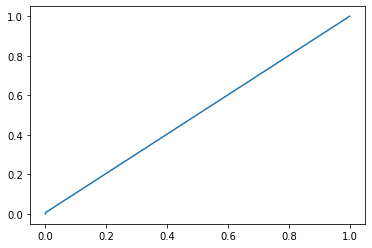

In [27]:
rfc=RandomForestClassifier()
evaluationClassification(rfc)

In [114]:
risque=data[data_rfc["TARGET"]==1]
non_risque=data[data_rfc["TARGET"]==0].sample(n=24825)

new=dd.concat([risque,non_risque]).compute()
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

* equilibre manuelle

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.67      4942
         1.0       0.67      0.66      0.66      4988

    accuracy                           0.66      9930
   macro avg       0.66      0.66      0.66      9930
weighted avg       0.66      0.66      0.66      9930

[[3310 1632]
 [1696 3292]]
accuracy 0.6648539778449144
auc  0.6648766428339387
roc_auc_score  0.6648766428339387
f1 score :  0.6642453591606134


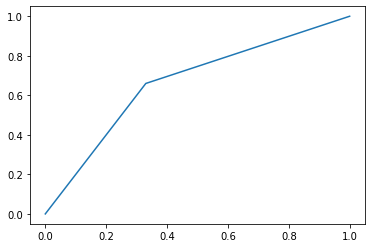

In [115]:
rfc=RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=4,criterion= 'gini',max_features= 'auto')
evaluationClassification(rfc)

* data augmentation

In [109]:
X,y=preprocessing(data_rfc)

In [30]:
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56441
         1.0       0.38      0.01      0.02      5062

    accuracy                           0.92     61503
   macro avg       0.65      0.50      0.49     61503
weighted avg       0.87      0.92      0.88     61503

[[56373    68]
 [ 5020    42]]
accuracy 0.9172723281791132
auc  0.5035461589169689
roc_auc_score  0.5035461589169689
f1 score :  0.016241299303944315


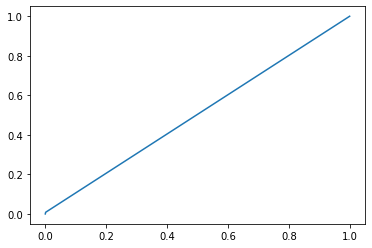

In [31]:
rfc=RandomForestClassifier()
evaluationClassification(rfc)

In [110]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100,200,500],
    'max_depth' : [4,5,6,7],
   'criterion' :['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,n_jobs=-1)
CV_rfc.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]})

In [112]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 100}

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56538     0]
 [ 4965     0]]
accuracy 0.9192722306228964
auc  0.5
roc_auc_score  0.5
f1 score :  0.0


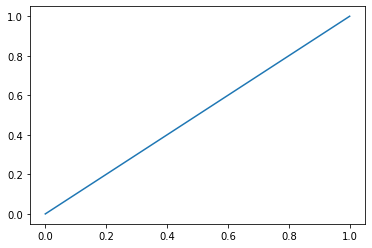

In [113]:
rfc=RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=4,criterion= 'gini',max_features= 'auto')
evaluationClassification(rfc)

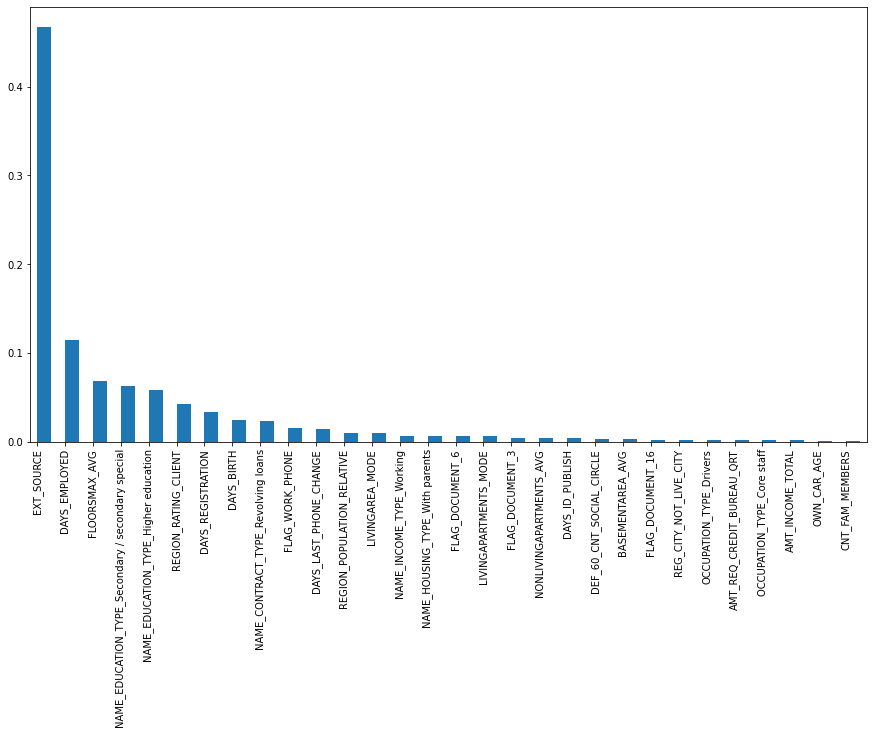

In [100]:
import pandas as pd
plt.figure(figsize=(15,8))
feature_importance= pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.show()

In [40]:
from sklearn.tree import export_graphviz
import pydotplus
def save_decision_trees_as_png(rfc, iteration, feature_name, target_name):
    file_name = "risk" + str(iteration) + ".png"
    dot_data = export_graphviz(
        rfc,
        out_file=None,
        feature_names=feature_name,
        class_names=target_name,
        rounded=True,
        proportion=False,
        precision=2,
        filled=True,
    )
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png(file_name)
    print("Decision Tree {} saved as png file".format(iteration + 1))

In [ ]:
for i in range(len(rfc.estimators_)):
    save_decision_trees_as_png(rfc.estimators_[i], i, X_train.columns, ["0","1"])

* RandomForestClassifier est mieux que DecisionTree au niveau du dressage de l'arbre de decision 
* DecisionTree est plus précis au niveau du prédicition

<h1>TPOT</h1>

In [15]:
from tpot import TPOTClassifier

In [9]:
X,y=preprocessing(data)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20, random_state=42)

tpot = TPOTClassifier(generations=5,verbosity=2)
tpot.fit(X_train, y_train)

                                                                                    
                                                                                    
TPOT closed during evaluation in one generation.
                                                                                    
                                                                                    
TPOT closed prematurely. Will use the current best pipeline.
                                                                                    
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.001, max_depth=1, max_features=0.9000000000000001, min_samples_leaf=11, min_samples_split=11, n_estimators=100, subsample=0.3)


TPOTClassifier(generations=5, verbosity=2)

In [12]:
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

0.9195323805342829


<h1>Gradient Boosting Classifier</h1>

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
exported_pipeline = GradientBoostingClassifier(learning_rate=0.001, max_depth=1, max_features=0.9000000000000001, min_samples_leaf=11, min_samples_split=11, n_estimators=100, subsample=0.3)

In [34]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56550
         1.0       0.00      0.00      0.00      4953

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

[[56550     0]
 [ 4953     0]]
accuracy 0.9194673430564363
auc  0.5
roc_auc_score  0.5
f1 score :  0.0


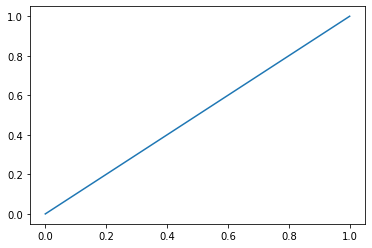

In [35]:
evaluationClassification(exported_pipeline)

In [36]:
risque=data[data["TARGET"]==1]
non_risque=data[data["TARGET"]==0].sample(n=24825)

new=dd.concat([risque,non_risque]).compute()
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

              precision    recall  f1-score   support

         0.0       0.63      0.73      0.68      4906
         1.0       0.69      0.58      0.63      5024

    accuracy                           0.66      9930
   macro avg       0.66      0.66      0.66      9930
weighted avg       0.66      0.66      0.66      9930

[[3603 1303]
 [2102 2922]]
accuracy 0.6570996978851964
auc  0.6580075645057007
roc_auc_score  0.6580075645057007
f1 score :  0.6318520921180668


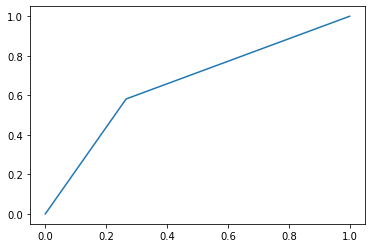

In [37]:
evaluationClassification(exported_pipeline)

In [19]:
tpot = TPOTClassifier(generations=1,verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

                                                                                
                                                                                
TPOT closed during evaluation in one generation.
                                                                                
                                                                                
TPOT closed prematurely. Will use the current best pipeline.


: 

<h1>Bagging</h1>

In [38]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier 

In [ ]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)
model = BaggingClassifier(base_estimator=RandomForestClassifier())
evaluationClassification(model)

In [118]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

In [40]:
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56452
         1.0       0.28      0.02      0.04      5051

    accuracy                           0.92     61503
   macro avg       0.60      0.51      0.50     61503
weighted avg       0.87      0.92      0.88     61503

[[56179   273]
 [ 4943   108]]
accuracy 0.9151911288880217
auc  0.5082729688671337
roc_auc_score  0.5082729688671337
f1 score :  0.039764359351988215


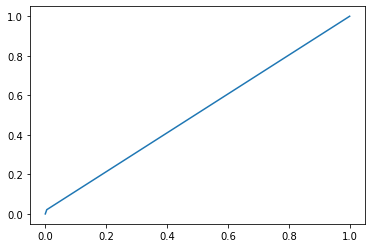

In [41]:
evaluationClassification(classifier)

<h1>Threshold moving</h1>

In [119]:
rf_model = RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=4,criterion= 'gini',max_features= 'auto')
rf_model.fit(X_train,y_train)   
rf_model.predict_proba(X_test)

array([[0.92559501, 0.07440499],
       [0.92759326, 0.07240674],
       [0.86675387, 0.13324613],
       ...,
       [0.93423836, 0.06576164],
       [0.89022791, 0.10977209],
       [0.8690999 , 0.1309001 ]])

In [120]:
step_factor = 0.05 
threshold_value = 0.2 
roc_score=0
predicted_proba = rf_model.predict_proba(X_test)
while threshold_value <=0.8: 
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') 
    print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
    if roc_score<roc_auc_score(y_test, predicted): 
        roc_score = roc_auc_score(y_test, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

Threshold 0.2 -- 0.5
Threshold 0.25 -- 0.5
Threshold 0.3 -- 0.5
Threshold 0.35 -- 0.5
Threshold 0.39999999999999997 -- 0.5
Threshold 0.44999999999999996 -- 0.5
Threshold 0.49999999999999994 -- 0.5
Threshold 0.5499999999999999 -- 0.5
Threshold 0.6 -- 0.5
Threshold 0.65 -- 0.5
Threshold 0.7000000000000001 -- 0.5
Threshold 0.7500000000000001 -- 0.5
---Optimum Threshold --- 0.2 --ROC-- 0.5


              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93     56478
         1.0       0.23      0.28      0.26      5025

    accuracy                           0.87     61503
   macro avg       0.58      0.60      0.59     61503
weighted avg       0.88      0.87      0.87     61503

[[51877  4601]
 [ 3612  1413]]
accuracy 0.8664617986114499
auc  0.5998643402555902
roc_auc_score  0.5998643402555902
f1 score :  0.25600144940664915


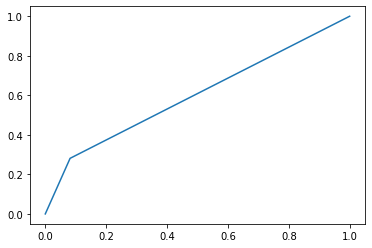

In [123]:
evaluationClassificationThreshold(RandomForestClassifier(),0.2)

In [45]:
rf_model = DecisionTreeClassifier()
rf_model.fit(X_train,y_train)   
rf_model.predict_proba(X_test)
BestThreshold(rf_model)

Threshold 0.2 -- 0.5342024318717311
Threshold 0.25 -- 0.5342024318717311
Threshold 0.3 -- 0.5342024318717311
Threshold 0.35 -- 0.5342024318717311
Threshold 0.39999999999999997 -- 0.5342024318717311
Threshold 0.44999999999999996 -- 0.5342024318717311
Threshold 0.49999999999999994 -- 0.5342024318717311
Threshold 0.5499999999999999 -- 0.5342024318717311
Threshold 0.6 -- 0.5342024318717311
Threshold 0.65 -- 0.5342024318717311
Threshold 0.7000000000000001 -- 0.5342024318717311
Threshold 0.7500000000000001 -- 0.5342024318717311
---Optimum Threshold --- 0.2 --ROC-- 0.5342024318717311


              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92     56452
         1.0       0.13      0.16      0.14      5051

    accuracy                           0.85     61503
   macro avg       0.53      0.53      0.53     61503
weighted avg       0.86      0.85      0.85     61503

[[51342  5110]
 [ 4259   792]]
accuracy 0.8476659675137798
auc  0.5331406271211142
roc_auc_score  0.5331406271211142
f1 score :  0.14461791290057519


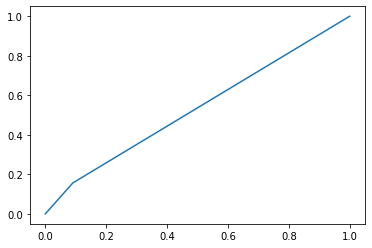

In [46]:
evaluationClassificationThreshold(DecisionTreeClassifier(),0.2)

<h1>XGBOOST</h1>

In [79]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

In [80]:
from xgboost import XGBClassifier

In [92]:
model = XGBClassifier(task_type='GPU', iterations=100, 
                              random_state = 2021, 
                              eval_metric="auc",boost_from_average=False)

In [89]:
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

[11:09:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "boost_from_average", "iterations", "task_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [90]:
confusion_matrix(y_test, y_pred)

array([[56393,    90],
       [ 4935,    85]], dtype=int64)

In [91]:
risque=data[data["TARGET"]==1]
non_risque=data[data["TARGET"]==0].sample(n=24825)

new=dd.concat([risque,non_risque]).compute()
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

[11:11:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "boost_from_average", "iterations", "task_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

         0.0       0.69      0.68      0.69      5002
         1.0       0.68      0.68      0.68      4928

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930

[[3422 1580]
 [1560 3368]]
accuracy 0.6837865055387714
auc  0.6837839539508872
roc_auc_score  0.6837839539508872
f1 score :  0.6820575131632238


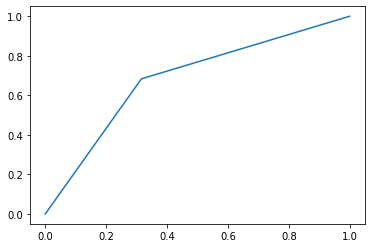

In [93]:
evaluationClassification(model)

In [94]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

In [95]:
model = XGBClassifier(task_type='GPU', iterations=100, 
                              random_state = 2021, 
                              eval_metric="auc",boost_from_average=False)
model.fit(X_train,y_train)   
model.predict_proba(X_test)
BestThreshold(model)

[11:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "boost_from_average", "iterations", "task_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Threshold 0.2 -- 0.606229304859607
Threshold 0.25 -- 0.573864669768184
Threshold 0.3 -- 0.5516018078859539
Threshold 0.35 -- 0.5348123003301097
Threshold 0.39999999999999997 -- 0.5192352619542117
Threshold 0.44999999999999996 -- 0.5115900468776902
Threshold 0.49999999999999994 -- 0.5056067156511533
Threshold 0.5499999999999999 -- 0.5032003242068581
Threshold 0.6 -- 0.5014534043976749
Threshold 0.65 -- 0.500928274462494
Threshold 0.7000000000000001 -- 0.5003677725914071
Threshold 0.7500000000000001 -- 0.5000742571798987
---Optimum Threshold 

[11:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93     56542
         1.0       0.26      0.28      0.27      4961

    accuracy                           0.88     61503
   macro avg       0.60      0.61      0.60     61503
weighted avg       0.88      0.88      0.88     61503

[[52667  3875]
 [ 3567  1394]]
accuracy 0.8789977724663838
auc  0.606229304859607
roc_auc_score  0.606229304859607
f1 score :  0.27253176930596285


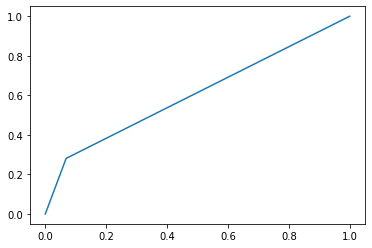

In [96]:
evaluationClassificationThreshold(XGBClassifier(),0.2)

<h1>CATBOOST</h1>

In [18]:
X,y=preprocessing(data)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score


model_cb = CatBoostClassifier(task_type='GPU', iterations=100, 
                              random_state = 2021, 
                              eval_metric="F1",boost_from_average=False)
                              
model_cb.fit(X_train, y_train,  plot=True, eval_set=(X_test, y_test))

y_pred = model_cb.predict(X_test)

confusion_matrix(y_test, y_pred)

In [21]:
risque=data[data["TARGET"]==1]
non_risque=data[data["TARGET"]==0].sample(n=24825)

new=dd.concat([risque,non_risque]).compute()
X,y=preprocessing(new)
X_train, X_test, y_train ,y_test =train_test_split(X,y,test_size=0.2)

In [22]:
model_cb = CatBoostClassifier(task_type='GPU', iterations=100, 
                              random_state = 2021, 
                              eval_metric="F1",boost_from_average=False)
                              
model_cb.fit(X_train, y_train,  plot=True, eval_set=(X_test, y_test))

y_pred = model_cb.predict(X_test)

confusion_matrix(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.135086
0:	learn: 0.6798467	test: 0.6775534	best: 0.6775534 (0)	total: 19.2ms	remaining: 1.91s
1:	learn: 0.6687399	test: 0.6678138	best: 0.6775534 (0)	total: 27.8ms	remaining: 1.36s
2:	learn: 0.6737580	test: 0.6724482	best: 0.6775534 (0)	total: 36.6ms	remaining: 1.18s
3:	learn: 0.6662439	test: 0.6657841	best: 0.6775534 (0)	total: 45ms	remaining: 1.08s
4:	learn: 0.6640029	test: 0.6629652	best: 0.6775534 (0)	total: 54.1ms	remaining: 1.03s
5:	learn: 0.6604524	test: 0.6587137	best: 0.6775534 (0)	total: 62.6ms	remaining: 980ms
6:	learn: 0.6614722	test: 0.6594908	best: 0.6775534 (0)	total: 70.7ms	remaining: 940ms
7:	learn: 0.6637220	test: 0.6650211	best: 0.6775534 (0)	total: 80ms	remaining: 920ms
8:	learn: 0.6670242	test: 0.6644824	best: 0.6775534 (0)	total: 89.3ms	remaining: 903ms
9:	learn: 0.6674348	test: 0.6660511	best: 0.6775534 (0)	total: 98.4ms	remaining: 886ms
10:	learn: 0.6684745	test: 0.6664613	best: 0.6775534 (0)	total: 107ms	remaining: 869ms
11:	learn: 0.6710

array([[3423, 1571],
       [1595, 3341]], dtype=int64)